# Advance use of Recurrent Networks

We’ll review three advanced techniques for improving the performance and generalization power of recurrent neural networks. We’ll demonstrate all three concepts on a temperature-forecasting problem, where we have access to a timeseries of data points coming from sensors installed on the roof of a building, such as temperature, air pressure, and humidity, which we use to predict what the temperature will be 24 hours after the last data point. We’ll cover the following techniques:
 - **Recurrent dropout—** This is a specific, built-in way to use dropout to fight overfitting in recurrent layers.
 - **Stacking recurrent layers—** This increases the representational power of the network (at the cost of higher computational loads).
 - **Bidirectional recurrent layers—** These present the same information to a recurrent network in different ways, increasing accuracy and mitigating forgetting issues.
 
### Temperature-Forecasting Problem

Link: https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip

In this dataset, 14 different quantities (such air temperature, atmospheric pressure, humidity, wind direction, and so on) were recorded every 10 minutes, over several years. The original data goes back to 2003, but this example is limited to data from 2009–2016. This dataset is perfect for learning to work with numerical timeseries. We’ll use it to build a model that takes as input some data from the recent past (a few days’ worth of data points) and predicts the air temperature 24 hours in the future.

### Inspect The Data of Jena Weather Dataset

In [14]:
import os

fname = os.path.join('jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


Now, convert all 420,551 lines of data into a Numpy array.

### Parse the Data

In [15]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

### Plott The Temperature Timeseries

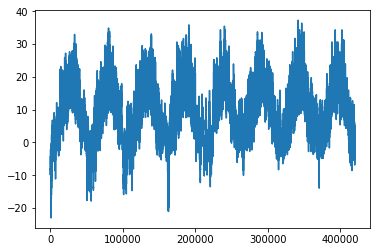

In [16]:
from matplotlib import pyplot as plt

temp = float_data[:, 1]  # temperature (in degrees Celsius)
plt.plot(range(len(temp)), temp)
plt.show()

### Plot The First 10 Days of The Temperature Timeseries
Here is a more narrow plot of the first 10 days of temperature data. Because the data is recorded every 10 minutes, we get 144 data points per day.

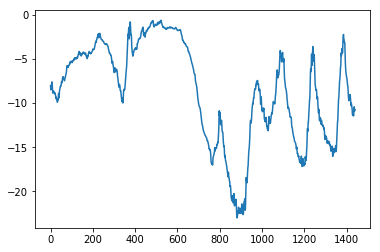

In [17]:
plt.plot(range(1440), temp[:1440])
plt.show()

On this plot, we can see daily periodicity, especially evident for the last 4 days. Also note that this 10-day period must be coming from a fairly cold winter month.

If we were trying to predict average temperature for the next month given a few months of past data, the problem would be easy, due to the reliable year-scale periodicity of the data. But looking at the data over a scale of days, the temperature looks a
lot more chaotic. Is this timeseries predictable at a daily scale? Let’s find out.

### Prepare The Data
The exact formulation of the problem will be as follows: given data going as far back as `lookback` timesteps (a timestep is 10 minutes) and sampled every steps timesteps, can we predict the temperature in delay timesteps? We’ll use the following parameter
values:
 - **`lookback = 720`** — Observations will go back 5 days.
 - **`steps = 6`** — Observations will be sampled at one data point per hour.
 - **`delay = 144`** — Targets will be 24 hours in the future.
 
To get started, you need to do two things:

 - Preprocess the data to a format a neural network can ingest. This is easy: the data is already numerical, so you don’t need to do any vectorization. But each timeseries in the data is on a different scale (for example, temperature is typically between -20 and +30, but atmospheric pressure, measured in mbar, is around 1,000). We’ll normalize each timeseries independently so that they all take small values on a similar scale.
 - Write a Python generator that takes the current array of float data and yields batches of data from the recent past, along with a target temperature in the future. Because the samples in the dataset are highly redundant (sample N and sample N + 1 will have most of their timesteps in common), it would be wasteful to explicitly allocate every sample. Instead, we’ll generate the samples on the fly using the original data.

We’ll preprocess the data by subtracting the mean of each timeseries and dividing by the standard deviation. We’re going to use the first 200,000 timesteps as training data, so compute the mean and standard deviation only on this fraction of the data.

### Normalize The Data

In [18]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

Below listing shows the data generator we’ll use. It yields a tuple (samples, targets), where samples is one batch of input data and targets is the corresponding array of target temperatures. It takes the following arguments:
 - **`data`** — The original array of floating-point data, which we normalized.
 - **`lookback`**— How many timesteps back the input data should go.
 - **`delay`** — How many timesteps in the future the target should be.
 - **`min_index`** and **`max_index`** — Indices in the data array that delimit which timesteps to draw from. This is useful for keeping a segment of the data for validation and another for testing.
 - **`shuffle`** — Whether to shuffle the samples or draw them in chronological order.
 - **`batch_size`** —The number of samples per batch.
 - **`step`** — The period, in timesteps, at which we sample data. We’ll set it to 6 in order to draw one data point every hour.
 
### Generator Yields Timeseries Samples and Their Targets

In [19]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

Now, let’s use the abstract `generator` function to instantiate three generators: one for training, one for validation, and one for testing. Each will look at different temporal segments of the original data: the training generator looks at the first 200,000 timesteps, the validation generator looks at the following 100,000, and the test generator looks at the remainder.

### Prepare The Training, Validation and Test Generators

In [20]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

In [21]:
# This is how many steps to draw from `val_gen` in order to see the whole validation set:
val_steps = (300000 - 200001 - lookback) // batch_size

# This is how many steps to draw from `test_gen` in order to see the whole test set:
test_steps = (len(float_data) - 300001 - lookback) // batch_size

### A common-sense, non-machine-learning baseline

Before we start using black-box deep-learning models to solve the temperature prediction problem, let’s try a simple, common-sense approach. It will serve as a sanity check, and it will establish a baseline that we’ll have to beat in order to demonstrate the usefulness of more-advanced machine-learning models. Such common-sense baselines can be useful when we’re approaching a new problem for which there is no known solution (yet). A classic example is that of unbalanced classification tasks, where some classes are much more common than others. If our dataset contains 90% instances of class A and 10% instances of class B, then a common-sense approach to the classification task is to always predict “A” when presented with a new sample. Such a classifier is 90% accurate overall, and any learning-based approach should therefore beat this 90% score in order to demonstrate usefulness. Sometimes, such elementary baselines can prove surprisingly hard to beat.

In this case, the temperature timeseries can safely be assumed to be continuous (the temperatures tomorrow are likely to be close to the temperatures today) as well as periodical with a daily period. Thus a common-sense approach is to always predict
that the temperature 24 hours from now will be equal to the temperature right now.

Let’s evaluate this approach, using the mean absolute error (MAE) metric: <br/>
`np.mean(np.abs(preds - targets))`

### Compute The Common-sense Baseline MAE

In [68]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.2897359729905486


This yields an MAE of 0.29. Because the temperature data has been normalized to be centered on 0 and have a standard deviation of 1, this number isn’t immediately interpretable. It translates to an average absolute error of 0.29 × temperature_std degrees
Celsius: 2.57°C.

### Convert The MAE Back to a Celsius Error

In [69]:
celsius_mae = 0.29 * std[1]
celsius_mae

2.5672247338393395

That’s a fairly large average absolute error. Now the game is to use our knowledge of deep learning to do better.

### A Basic Machine-Learning Approach
It’s useful to try simple, cheap machine-learning models (such as small, densely connected networks) before looking into complicated and computationally expensive models such as RNNs. This is the best way to make sure any further complexity we throw at the problem is legitimate and delivers real benefits.

The following listing shows a fully connected model that starts by flattening the data and then runs it through two Dense layers. Note the lack of activation function on the last Dense layer, which is typical for a regression problem. We use MAE as the loss. 

### Train and Evaluate a Densely Connected Model

In [70]:
from keras import Sequential
from keras import layers
from keras.optimizers import RMSprop

model=Sequential()
model.add(layers.Flatten(input_shape=(lookback//step, float_data.shape[-1])))
model.add(layers.Dense(32,activation='relu'))
model.add(layers.Dense(1))

In [71]:
model.compile(optimizer=RMSprop(), loss='mae')

In [72]:
history= model.fit_generator(train_gen, steps_per_epoch=500,
                            epochs=20, validation_data=val_gen, validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 9s 19ms/step - loss: 1.6750 - val_loss: 1.0250
Epoch 2/20
500/500 [==============================] - 9s 17ms/step - loss: 0.6666 - val_loss: 0.4713
Epoch 3/20
500/500 [==============================] - 8s 17ms/step - loss: 0.3752 - val_loss: 0.3421
Epoch 4/20
500/500 [==============================] - 8s 17ms/step - loss: 0.2973 - val_loss: 0.3288
Epoch 5/20
500/500 [==============================] - 8s 17ms/step - loss: 0.2708 - val_loss: 0.3075
Epoch 6/20
500/500 [==============================] - 8s 17ms/step - loss: 0.2573 - val_loss: 0.3320
Epoch 7/20
500/500 [==============================] - 8s 17ms/step - loss: 0.2476 - val_loss: 0.3143
Epoch 8/20
500/500 [==============================] - 9s 18ms/step - loss: 0.2421 - val_loss: 0.3368
Epoch 9/20
500/500 [==============================] - 8s 17ms/step - loss: 0.2354 - val_loss: 0.3419
Epoch 10/20
500/500 [==============================] - 8s 17ms/step - loss: 0.2302 - val_lo

Let’s display the loss curves for validation and training

### Plot results

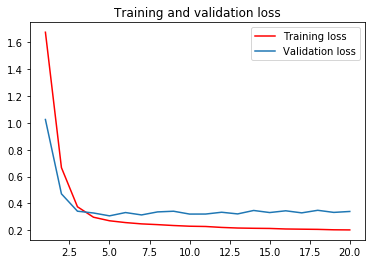

In [73]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Some of the validation losses are close to the no-learning baseline, but not reliably. This goes to show the merit of having this baseline in the first place: it turns out to be not easy to outperform. Our common sense contains a lot of valuable information that a machine-learning model doesn’t have access to.

If a simple, well-performing model exists to go from the data to the targets (the common-sense baseline), why doesn’t the model we’re training find it and improve on it? Because this simple solution isn’t what our training setup is looking for. The space of models in which we’re searching for a solution—that is, our hypothesis space—is the space of all possible two-layer networks with the configuration we defined. These networks are already fairly complicated. When we’re looking for a solution with a space of complicated models, the simple, well-performing baseline may be unlearnable, even if it’s technically part of the hypothesis space. That is a pretty significant limitation of machine learning in general: unless the learning algorithm is hardcoded to look for a specific kind of simple model, parameter learning can sometimes fail to find a simple solution to a simple problem.

### A First Recurrent Baseline
The first fully connected approach didn’t do well, but that doesn’t mean machine learning isn’t applicable to this problem. The previous approach first flattened the timeseries, which removed the notion of time from the input data. Let’s instead look
at the data as what it is: a sequence, where causality and order matter. We’ll try a recurrent-sequence processing model—it should be the perfect fit for such sequence data, precisely because it exploits the temporal ordering of data points, unlike the first approach.

Instead of the LSTM layer introduced in the previous section, we’ll use the GRU layer. **Gated recurrent unit (GRU)** layers work using the same principle as LSTM, but they’re somewhat streamlined and thus cheaper to run (although they may not have as much representational power as LSTM). This trade-off between computational expensiveness and representational power is seen everywhere in machine learning.

### Train and Evaluate a GRU-based Model

In [15]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model= Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

In [16]:
model.compile(optimizer=RMSprop(), loss='mae')

In [17]:
history= model.fit_generator(train_gen, steps_per_epoch=500, epochs=20,
                            validation_data= val_gen, validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 156s 312ms/step - loss: 0.3026 - val_loss: 0.2727
Epoch 2/20
500/500 [==============================] - 156s 313ms/step - loss: 0.2842 - val_loss: 0.2704
Epoch 3/20
500/500 [==============================] - 156s 313ms/step - loss: 0.2742 - val_loss: 0.2653
Epoch 4/20
500/500 [==============================] - 154s 309ms/step - loss: 0.2718 - val_loss: 0.2673
Epoch 5/20
500/500 [==============================] - 155s 310ms/step - loss: 0.2653 - val_loss: 0.2700
Epoch 6/20
500/500 [==============================] - 154s 308ms/step - loss: 0.2629 - val_loss: 0.2655
Epoch 7/20
500/500 [==============================] - 147s 294ms/step - loss: 0.2577 - val_loss: 0.2682
Epoch 8/20
500/500 [==============================] - 142s 283ms/step - loss: 0.2543 - val_loss: 0.2661
Epoch 9/20
500/500 [==============================] - 141s 282ms/step - loss: 0.2509 - val_loss: 0.2649
Epoch 10/20
500/500 [==============================] - 141s 282m

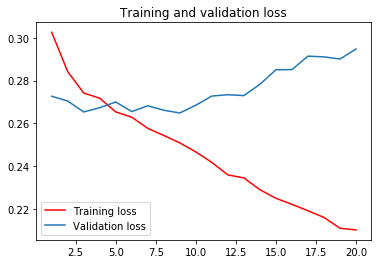

In [18]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Much better! We can significantly beat the commonsense baseline, demonstrating the value of machine learning as well as the superiority of recurrent networks compared to sequence-flattening dense networks on this type of task.
The new validation MAE of ~0.265 (before we start significantly overfitting) translates to a mean absolute error of 2.35°C after denormalization. That’s a solid gain on the initial error of 2.57°C, but we probably still have a bit of a margin for improvement.

### Use Recurrent Dropouts to Kill Overfitting
It’s evident from the training and validation curves that the model is overfitting: the training and validation losses start to diverge considerably after a few epochs. We’re already familiar with a classic technique for fighting this phenomenon: dropout,
which randomly zeros out input units of a layer in order to break happenstance correlations in the training data that the layer is exposed to. But how to correctly apply dropout in recurrent networks isn’t a trivial question. It has long been known that
applying dropout before a recurrent layer hinders learning rather than helping with regularization. In 2015, Yarin Gal, as part of his PhD thesis on Bayesian deep learning, 6 determined the proper way to use dropout with a recurrent network: the same
dropout mask (the same pattern of dropped units) should be applied at every timestep, instead of a dropout mask that varies randomly from timestep to timestep. What’s more, in order to regularize the representations formed by the recurrent gates
of layers such as GRU and LSTM, a temporally constant dropout mask should be applied to the inner recurrent activations of the layer (a recurrent dropout mask). Using the same dropout mask at every timestep allows the network to properly propagate its
learning error through time; a temporally random dropout mask would disrupt this error signal and be harmful to the learning process. 

Every recurrent layer in Keras has two dropout-related arguments: `dropout`, a float specifying the dropout rate for input units of the layer, and `recurrent_dropout`, specifying the dropout rate of the recurrent units. Let’s add dropout and recurrent dropout to the GRU layer and see how doing so impacts overfitting. Because networks being regularized with dropout always take longer to fully converge, we’ll train the network for twice as many epochs.


### Train and Evaluate a Dropout-regularized GRU-based Model

In [19]:
from keras.models import Sequential
from keras.layers import Dense, GRU
from keras.optimizers import RMSprop

In [20]:
model= Sequential()
model.add(GRU(32, input_shape=(None, float_data.shape[-1]), dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1))

In [21]:
model.compile(optimizer=RMSprop(), loss='mae')

In [22]:
history= model.fit_generator(train_gen, steps_per_epoch=500, epochs=40,
                            validation_data=val_gen, validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 166s 331ms/step - loss: 0.3392 - val_loss: 0.2761
Epoch 2/40
500/500 [==============================] - 161s 321ms/step - loss: 0.3141 - val_loss: 0.2703
Epoch 3/40
500/500 [==============================] - 162s 325ms/step - loss: 0.3078 - val_loss: 0.2702
Epoch 4/40
500/500 [==============================] - 159s 319ms/step - loss: 0.3031 - val_loss: 0.2682
Epoch 5/40
500/500 [==============================] - 160s 319ms/step - loss: 0.2994 - val_loss: 0.2683
Epoch 6/40
500/500 [==============================] - 171s 342ms/step - loss: 0.2991 - val_loss: 0.2668
Epoch 7/40
500/500 [==============================] - 159s 319ms/step - loss: 0.2952 - val_loss: 0.2658
Epoch 8/40
500/500 [==============================] - 170s 340ms/step - loss: 0.2945 - val_loss: 0.2663
Epoch 9/40
500/500 [==============================] - 160s 321ms/step - loss: 0.2911 - val_loss: 0.2647
Epoch 10/40
500/500 [==============================] - 159s 318m

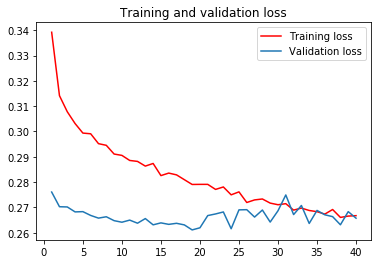

In [23]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

We can see that the added layer does improve the results a bit, though not significantly. We can draw two conclusions:
    
 - Because you’re still not overfitting too badly, you could safely increase the size of our layers in a quest for validation-loss improvement. This has a non-negligible computational cost, though.
 - Adding a layer didn’t help by a significant factor, so we may be seeing diminishing returns from increasing network capacity at this point.
 
### Use bidirectional RNNs

The last technique introduced in this section is called **bidirectional RNNs**. A bidirectional RNN is a common RNN variant that can offer greater performance than a regular RNN on certain tasks. It’s frequently used in natural-language processing.

RNNs are notably order dependent, or time dependent: they process the timesteps of their input sequences in order, and shuffling or reversing the timesteps can completely change the representations the RNN extracts from the sequence. This is precisely
the reason they perform well on problems where order is meaningful, such as the temperature-forecasting problem. A bidirectional RNN exploits the order sensitivity of RNNs: it consists of using two regular RNNs, such as the GRU and LSTM layers we’re already familiar with, each of which processes the input sequence in one direction (chronologically and antichronologically), and then merging their representations. By processing a sequence both ways, a bidirectional RNN can catch patterns that may be overlooked by a unidirectional RNN.

Remarkably, the fact that the RNN layers in this section have processed sequences in chronological order (older timesteps first) may have been an arbitrary decision. At least, it’s a decision we made no attempt to question so far. Could the RNNs have performed well enough if they processed input sequences in antichronological order, for instance (newer timesteps first)? Let’s try this in practice and see what happens. All you need to do is write a variant of the data generator where the input sequences are reverted along the time dimension (replace the last line with yield `samples[:, ::-1, :]`, `targets`). Training the same one-GRU-layer network that we used in the first experiment in this section.

In [24]:
def reverse_order_generator(data, lookback, delay, min_index, max_index,
                            shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples[:, ::-1, :], targets
        
train_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step, 
    batch_size=batch_size)
val_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size)

In [25]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen_reverse,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen_reverse,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 140s 280ms/step - loss: 0.4744 - val_loss: 0.4852
Epoch 2/20
500/500 [==============================] - 140s 279ms/step - loss: 0.4475 - val_loss: 0.4793
Epoch 3/20
500/500 [==============================] - 139s 278ms/step - loss: 0.4021 - val_loss: 0.4574
Epoch 4/20
500/500 [==============================] - 140s 279ms/step - loss: 0.3551 - val_loss: 0.4795
Epoch 5/20
500/500 [==============================] - 145s 289ms/step - loss: 0.3296 - val_loss: 0.4693
Epoch 6/20
500/500 [==============================] - 141s 282ms/step - loss: 0.3171 - val_loss: 0.4762
Epoch 7/20
500/500 [==============================] - 141s 281ms/step - loss: 0.3030 - val_loss: 0.4947
Epoch 8/20
500/500 [==============================] - 142s 284ms/step - loss: 0.2908 - val_loss: 0.4956
Epoch 9/20
500/500 [==============================] - 140s 281ms/step - loss: 0.2820 - val_loss: 0.4805
Epoch 10/20
500/500 [==============================] - 141s 282m

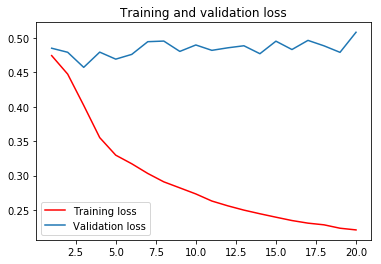

In [26]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

The reversed-order GRU strongly underperforms even the common-sense baseline, indicating that in this case, chronological processing is important to the success of our approach. This makes perfect sense: the underlying GRU layer will typically be better at remembering the recent past than the distant past, and naturally the more recent weather data points are more predictive than older data points for the problem (that’s what makes the common-sense baseline fairly strong). Thus the chronological version of the layer is bound to outperform the reversed-order version. Importantly, this isn’t true for many other problems, including natural language: intuitively, the importance of a word in understanding a sentence isn’t usually dependent on its position in the sentence. Let’s try the same trick on the LSTM IMDB example.

### Train And Evaluate An LSTM Using Reversed Sequences

In [1]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential 

Using TensorFlow backend.


In [32]:
max_features= 10000 #Number of words to consider as features
max_len=500 #Cuts off texts after this number of words (among the max_features most common words)

In [33]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

In [34]:
x_train=[x[::-1] for x in x_train] #Reverses
x_test=[x[::-1] for x in x_test]   #sequences

In [35]:
x_train= sequence.pad_sequences(x_train, maxlen=max_len) #Pad
x_test= sequence.pad_sequences(x_test, maxlen= max_len)  #sequences

In [36]:
model= Sequential()
model.add(layers.Embedding(max_features,128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

In [37]:
model.compile(optimizer='rmsprop', loss= 'binary_crossentropy', metrics=['acc'])

In [38]:
history= model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 93s 5ms/step - loss: 0.4898 - acc: 0.7665 - val_loss: 0.4662 - val_acc: 0.8170
Epoch 2/10
20000/20000 [==============================] - 92s 5ms/step - loss: 0.3063 - acc: 0.8836 - val_loss: 0.4460 - val_acc: 0.7908
Epoch 3/10
20000/20000 [==============================] - 92s 5ms/step - loss: 0.2547 - acc: 0.9050 - val_loss: 0.3460 - val_acc: 0.8536
Epoch 4/10
20000/20000 [==============================] - 93s 5ms/step - loss: 0.2213 - acc: 0.9201 - val_loss: 0.4562 - val_acc: 0.8634
Epoch 5/10
20000/20000 [==============================] - 95s 5ms/step - loss: 0.1937 - acc: 0.9311 - val_loss: 0.3420 - val_acc: 0.8766
Epoch 6/10
20000/20000 [==============================] - 93s 5ms/step - loss: 0.1716 - acc: 0.9394 - val_loss: 0.3897 - val_acc: 0.8758
Epoch 7/10
20000/20000 [==============================] - 94s 5ms/step - loss: 0.1620 - acc: 0.9461 - val_loss: 0.4216 - val_acc:

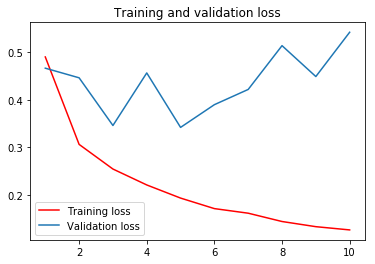

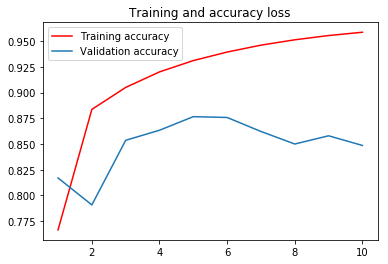

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, acc, color='red', label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and accuracy loss')
plt.legend()
plt.show()

We will get performance nearly identical to that of the chronological-order LSTM. Remarkably, on such a text dataset, reversed-order processing works just as well as chronological processing, confirming the hypothesis that, although word order does
matter in understanding language, which order we use isn’t crucial. Importantly, an RNN trained on reversed sequences will learn different representations than one trained on the original sequences.

In machine learning, representations that are different yet useful are always worth exploiting, and the more they differ, the better: they offer a new angle from which to look at our data, capturing aspects of the data that were missed by other approaches, and thus they can help boost performance on a task.

A bidirectional RNN exploits this idea to improve on the performance of chronologicalorder RNNs. It looks at its input sequence both ways, obtaining potentially richer representations and capturing patterns that may have been missed by the chronological-order version alone.

![capture](https://user-images.githubusercontent.com/13174586/51528244-3a924600-1e5c-11e9-9518-25c531b33844.JPG)

To instantiate a bidirectional RNN in Keras, we will use the `Bidirectional` layer, which takes as its first argument a recurrent layer instance. Bidirectional creates a second, separate instance of this recurrent layer and uses one instance for processing the input sequences in chronological order and the other instance for processing the input sequences in reversed order. Let’s try it on the IMDB sentiment-analysis task.

### Train And Evaluating A Bidirectional LSTM

In [40]:
model= Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))

In [41]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

In [42]:
history= model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 183s 9ms/step - loss: 0.5303 - acc: 0.7409 - val_loss: 0.3814 - val_acc: 0.8532
Epoch 2/10
20000/20000 [==============================] - 181s 9ms/step - loss: 0.3339 - acc: 0.8699 - val_loss: 0.4444 - val_acc: 0.8406
Epoch 3/10
20000/20000 [==============================] - 190s 9ms/step - loss: 0.2670 - acc: 0.9014 - val_loss: 0.3545 - val_acc: 0.8620
Epoch 4/10
20000/20000 [==============================] - 184s 9ms/step - loss: 0.2242 - acc: 0.9185 - val_loss: 0.4568 - val_acc: 0.8318
Epoch 5/10
20000/20000 [==============================] - 180s 9ms/step - loss: 0.2008 - acc: 0.9290 - val_loss: 0.3875 - val_acc: 0.8784
Epoch 6/10
20000/20000 [==============================] - 179s 9ms/step - loss: 0.1764 - acc: 0.9376 - val_loss: 0.4405 - val_acc: 0.8632
Epoch 7/10
20000/20000 [==============================] - 179s 9ms/step - loss: 0.1654 - acc: 0.9425 - val_loss: 0.4470 - v

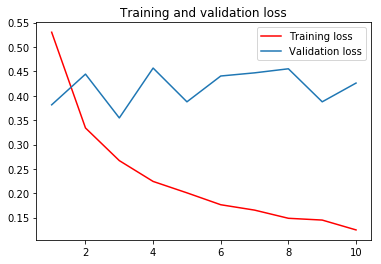

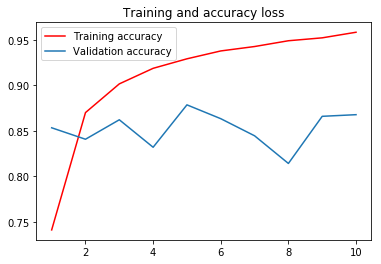

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, acc, color='red', label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and accuracy loss')
plt.legend()
plt.show()

It performs slightly better than the regular LSTM we tried in the previous section, achieving over 89% validation accuracy. It also seems to overfit more quickly, which is unsurprising because a bidirectional layer has twice as many parameters as a chronological LSTM. With some regularization, the bidirectional approach would likely be a strong performer on this task.

Now let’s try the same approach on the temperature-prediction task.

### Train A Bidirectional GRU

In [74]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

In [75]:
model=Sequential()
model.add(layers.Bidirectional(layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

In [76]:
model.compile(optimizer= RMSprop(), loss='mae')

In [79]:
history= model.fit_generator(train_gen, steps_per_epoch=500, epochs=40,
                  validation_data=val_gen, validation_steps= val_steps)

Epoch 1/40
500/500 [==============================] - 281s 562ms/step - loss: 0.2908 - val_loss: 0.2655
Epoch 2/40
500/500 [==============================] - 281s 563ms/step - loss: 0.2749 - val_loss: 0.2679
Epoch 3/40
500/500 [==============================] - 281s 562ms/step - loss: 0.2672 - val_loss: 0.2661
Epoch 4/40
500/500 [==============================] - 285s 570ms/step - loss: 0.2612 - val_loss: 0.2703
Epoch 5/40
500/500 [==============================] - 283s 566ms/step - loss: 0.2548 - val_loss: 0.2767
Epoch 6/40
500/500 [==============================] - 282s 564ms/step - loss: 0.2497 - val_loss: 0.2659
Epoch 7/40
500/500 [==============================] - 281s 562ms/step - loss: 0.2430 - val_loss: 0.2691
Epoch 8/40
500/500 [==============================] - 284s 567ms/step - loss: 0.2356 - val_loss: 0.2840
Epoch 9/40
500/500 [==============================] - 282s 564ms/step - loss: 0.2300 - val_loss: 0.2856
Epoch 10/40
500/500 [==============================] - 285s 569m

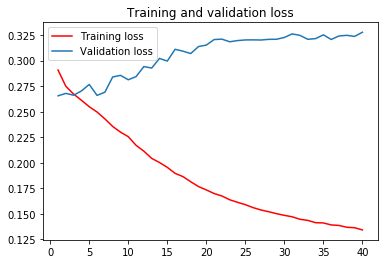

In [84]:
import matplotlib.pyplot as plt
%matplotlib inline
history.history

loss = history.history['loss']
val_loss = history.history['val_loss']

#acc = history.history['acc']
#val_acc = history.history['val_acc']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

This performs about as well as the regular GRU layer. It’s easy to understand why: all the predictive capacity must come from the chronological half of the network, because the antichronological half is known to be severely underperforming on this task (again, because the recent past matters much more than the distant past in this case).

### Sequence Processing With Convnets

We learned about convolutional neural networks (convnets) and how they perform particularly well on computer vision problems, due to their ability to operate convolutionally, extracting features from local input patches and allowing for representation modularity and data efficiency. The same properties that make convnets excel at computer vision also make them highly relevant to sequence processing. Time can be treated as a spatial dimension, like the height or width of a 2D image.

Such 1D convnets can be competitive with RNNs on certain sequence-processing problems, usually at a considerably cheaper computational cost. It has long been known that small 1D convnets can offer a fast alternative to RNNs for simple tasks such as text classification and timeseries forecasting.

### Understanding 1D Convolution for Sequence Data

The convolution layers introduced previously were 2D convolutions, extracting 2D patches from image tensors and applying an identical transformation to every patch. In the same way, we can use 1D convolutions, extracting local 1D patches (subsequences)
from sequences.

![capture](https://user-images.githubusercontent.com/13174586/51594091-abe3fe80-1f19-11e9-99c5-75e5d3c930dd.JPG)

Such 1D convolution layers can recognize local patterns in a sequence. Because the same input transformation is performed on every patch, a pattern learned at a certain position in a sentence can later be recognized at a different position, making 1D convnets translation invariant (for temporal translations). For instance, a 1D convnet processing sequences of characters using convolution windows of size 5 should be able to learn words or word fragments of length 5 or less, and it should be able to recognize these words in any context in an input sequence. A character-level 1D convnet is thus able to learn about word morphology.

### 1D Pooling for Sequence Data

We’re already familiar with 2D pooling operations, such as 2D average pooling and max pooling, used in convnets to spatially downsample image tensors. The 2D pooling operation has a 1D equivalent: extracting 1D patches (subsequences) from an input
and outputting the maximum value (max pooling) or average value (average pooling). Just as with 2D convnets, this is used for reducing the length of 1D inputs (subsampling).

### Implement a 1D Convnet

In Keras, we use a 1D convnet via the `Conv1D` layer, which has an interface similar to `Conv2D`. It takes as input 3D tensors with shape (samples, time, features) and returns similarly shaped 3D tensors. The convolution window is a 1D window on the temporal axis: axis 1 in the input tensor.

Let’s build a simple two-layer 1D convnet and apply it to the IMDB sentimentclassification task we’re already familiar with. As a reminder, this is the code for obtaining and preprocessing the data.

### Prepare The IMDB Data

In [4]:
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features=10000
max_len=500

print("loading data...")
(x_train, y_train), (x_test, y_test)= imdb.load_data(num_words= max_features)
print(len(x_train), "train sequence")
print(len(x_test), "test sequence")
x_train.shape

loading data...
25000 train sequence
25000 test sequence


(25000,)

In [6]:
print('Pad Sequences (samples x time)')
x_train= sequence.pad_sequences(x_train, max_len)
x_test= sequence.pad_sequences(x_test, max_len)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Pad Sequences (samples x time)
x_train shape: (25000, 500)
x_test shape: (25000, 500)


1D convnets are structured in the same way as their 2D counterparts, which we used earlier: they consist of a stack of Conv1D and MaxPooling1D layers, ending in either a global pooling layer or a Flatten layer, that turn the 3D outputs into 2D outputs, allowing us to add one or more Dense layers to the model for classification or regression.

One difference, though, is the fact that we can afford to use larger convolution windows with 1D convnets. With a 2D convolution layer, a 3 × 3 convolution window contains 3 × 3 = 9 feature vectors; but with a 1D convolution layer, a convolution window of size 3 contains only 3 feature vectors. We can thus easily afford 1D convolution windows of size 7 or 9.

### Train and Evaluate A Simple 1D Convnet on The IMDB Data

In [9]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model= Sequential()
model.add(layers.Embedding(max_features, 128, input_length= max_len))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 500, 128)          1280000   
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 98, 32)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,315,937
Trainable params: 1,315,937
Non-trainable params: 0
_________________________________________________________________


In [10]:
model.compile(optimizer=RMSprop(lr=1e-4), loss='binary_crossentropy', metrics=['acc'])

In [11]:
history= model.fit(x_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 6s 278us/step - loss: 0.7290 - acc: 0.5254 - val_loss: 0.6842 - val_acc: 0.5804
Epoch 2/10
20000/20000 [==============================] - 2s 110us/step - loss: 0.6636 - acc: 0.6784 - val_loss: 0.6661 - val_acc: 0.6038
Epoch 3/10
20000/20000 [==============================] - 2s 109us/step - loss: 0.6190 - acc: 0.7758 - val_loss: 0.6085 - val_acc: 0.7482
Epoch 4/10
20000/20000 [==============================] - 2s 111us/step - loss: 0.5240 - acc: 0.8184 - val_loss: 0.4875 - val_acc: 0.8006
Epoch 5/10
20000/20000 [==============================] - 2s 108us/step - loss: 0.4037 - acc: 0.8492 - val_loss: 0.4137 - val_acc: 0.8320
Epoch 6/10
20000/20000 [==============================] - 2s 107us/step - loss: 0.3378 - acc: 0.8682 - val_loss: 0.4110 - val_acc: 0.8302
Epoch 7/10
20000/20000 [==============================] - 2s 108us/step - loss: 0.2943 - acc: 0.8727 - val_loss: 0.4001 - v

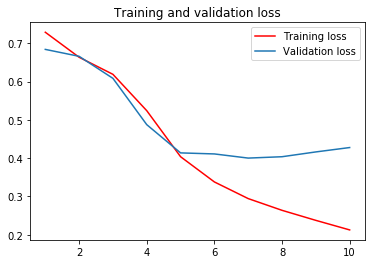

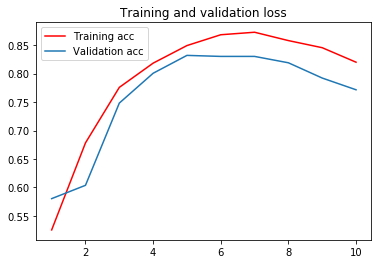

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
history.history

loss = history.history['loss']
val_loss = history.history['val_loss']

acc = history.history['acc']
val_acc = history.history['val_acc']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, acc, color='red', label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Validation accuracy is somewhat less than that of the LSTM, but runtime is faster on both CPU and GPU (the exact increase in speed will vary greatly depending on your exact configuration). At this point, we could retrain this model for the right number of epochs (eight) and run it on the test set. This is a convincing demonstration that a 1D convnet can offer a fast, cheap alternative to a recurrent network on a word-level sentiment-classification task.

### Combine CNNs and RNNs to Process long Sequences

Because 1D convnets process input patches independently, they aren’t sensitive to the order of the timesteps (beyond a local scale, the size of the convolution windows), unlike RNNs. Of course, to recognize longer-term patterns, we can stack many convolution layers and pooling layers, resulting in upper layers that will see long chunks of the original inputs—but that’s still a fairly weak way to induce order sensitivity. One way to evidence this weakness is to try 1D convnets on the temperature-forecasting problem, where order-sensitivity is key to producing good predictions. The following example reuses the following variables defined previously: `float_data`, `train_gen`, `val_gen`, and `val_steps`.

### Train and Evaluate a Simple 1D Convnet on The Jena Data

In [32]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model= Sequential()
model.add(layers.Conv1D(32, 5, activation ='relu', input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32,5, activation='relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32,5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_13 (Conv1D)           (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, None, 32)          5152      
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, None, 32)          5152      
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total para

In [33]:
model.compile(optimizer= RMSprop(lr=1e-5), loss='mae')

In [34]:
model.fit_generator(train_gen, steps_per_epoch=500, epochs=100, 
                    validation_data=val_gen, validation_steps=val_steps)

Epoch 1/100
500/500 [==============================] - 8s 17ms/step - loss: 0.5115 - val_loss: 0.4554
Epoch 2/100
500/500 [==============================] - 8s 17ms/step - loss: 0.4641 - val_loss: 0.4486
Epoch 3/100
500/500 [==============================] - 8s 17ms/step - loss: 0.4505 - val_loss: 0.4460
Epoch 4/100
500/500 [==============================] - 8s 17ms/step - loss: 0.4416 - val_loss: 0.4447
Epoch 5/100
500/500 [==============================] - 8s 17ms/step - loss: 0.4345 - val_loss: 0.4433
Epoch 6/100
500/500 [==============================] - 8s 17ms/step - loss: 0.4315 - val_loss: 0.4401
Epoch 7/100
500/500 [==============================] - 8s 17ms/step - loss: 0.4261 - val_loss: 0.4414
Epoch 8/100
500/500 [==============================] - 8s 17ms/step - loss: 0.4198 - val_loss: 0.4379
Epoch 9/100
500/500 [==============================] - 8s 17ms/step - loss: 0.4174 - val_loss: 0.4395
Epoch 10/100
500/500 [==============================] - 9s 17ms/step - loss: 0.414

500/500 [==============================] - 8s 17ms/step - loss: 0.3169 - val_loss: 0.4516
Epoch 81/100
500/500 [==============================] - 8s 17ms/step - loss: 0.3176 - val_loss: 0.4525
Epoch 82/100
500/500 [==============================] - 8s 17ms/step - loss: 0.3163 - val_loss: 0.4507
Epoch 83/100
500/500 [==============================] - 9s 17ms/step - loss: 0.3171 - val_loss: 0.4534
Epoch 84/100
500/500 [==============================] - 9s 18ms/step - loss: 0.3147 - val_loss: 0.4529
Epoch 85/100
500/500 [==============================] - 9s 17ms/step - loss: 0.3162 - val_loss: 0.4546
Epoch 86/100
500/500 [==============================] - 9s 17ms/step - loss: 0.3138 - val_loss: 0.4527
Epoch 87/100
500/500 [==============================] - 8s 17ms/step - loss: 0.3131 - val_loss: 0.4537
Epoch 88/100
500/500 [==============================] - 8s 17ms/step - loss: 0.3123 - val_loss: 0.4567
Epoch 89/100
500/500 [==============================] - 8s 17ms/step - loss: 0.3121 - 

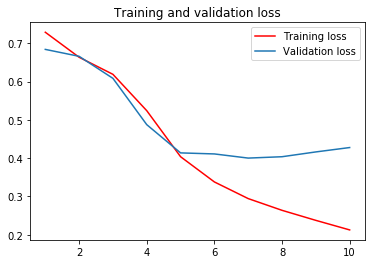

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline
history.history

loss = history.history['loss']
val_loss = history.history['val_loss']

#acc = history.history['acc']
#val_acc = history.history['val_acc']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

#plt.figure()
#plt.plot(epochs, acc, color='red', label='Training acc')
#plt.plot(epochs, val_acc, label='Validation acc')
#plt.title('Training and validation loss')
#plt.legend()
#plt.show()

The validation MAE stays in the 0.40s: we can’t even beat the common-sense baseline using the small convnet. Again, this is because the convnet looks for patterns anywhere in the input timeseries and has no knowledge of the temporal position of a pattern it sees (toward the beginning, toward the end, and so on). Because more recent data points should be interpreted differently from older data points in the case of this specific forecasting problem, the convnet fails at producing meaningful results. This limitation of convnets isn’t an issue with the IMDB data, because patterns of keywords associated with a positive or negative sentiment are informative independently of where they’re found in the input sentences.

One strategy to combine the speed and lightness of convnets with the order-sensitivity of RNNs is to use a 1D convnet as a preprocessing step before an RNN. This is especially beneficial when we’re dealing with sequences that are so long they can’t
realistically be processed with RNNs, such as sequences with thousands of steps. The convnet will turn the long input sequence into much shorter (downsampled) sequences of higher-level features. This sequence of extracted features then becomes the input to the RNN part of the network.

![capture](https://user-images.githubusercontent.com/13174586/51599903-bce73c80-1f26-11e9-892f-e96feb4f10e7.JPG)

This technique isn’t seen often in research papers and practical applications, possibly because it isn’t well known. It’s effective and ought to be more common. Let’s try it on the temperature-forecasting dataset. Because this strategy allows us to manipulate much longer sequences, we can either look at data from longer ago (by increasing the lookback parameter of the data generator) or look at high-resolution timeseries (by decreasing the step parameter of the generator). Here, somewhat arbitrarily, you’ll use a step that’s half as large, resulting in a timeseries twice as long, where the temperature data is sampled at a rate of 1 point per 30 minutes. The example reuses the generator function defined earlier.

### Prepare Higher-Resolution Data Generators for The Jena Dataset

In [54]:
step=3
lookback=720
delay=144

train_gen= generator(float_data, lookback=lookback, delay=delay, min_index=0, max_index=200000, shuffle=True, step=step)

val_gen= generator(float_data, lookback=lookback, delay=delay, min_index=200001, max_index=300000, step=step)

test_gen= generator(float_data, lookback=lookback, delay=delay, min_index=300001, max_index=None, step=step)

val_steps= (300000-200001-lookback)//128
test_steps= (len(float_data)-300001-lookback)//128

### Model Combining a 1D Convolutional Base and a GRU Layer

In [55]:
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras import layers

model= Sequential()
model.add(layers.Conv1D(32, 5, activation='relu', input_shape= (None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GRU(32, dropout= 0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_22 (Conv1D)           (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, None, 32)          0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, None, 32)          5152      
_________________________________________________________________
gru_4 (GRU)                  (None, 32)                6240      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 13,697
Trainable params: 13,697
Non-trainable params: 0
_________________________________________________________________


In [56]:
model.compile(optimizer=RMSprop(lr=1e-5), loss='mae')

In [57]:
history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=20, validation_data=val_gen, validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 36s 72ms/step - loss: 0.4879 - val_loss: 0.3778
Epoch 2/20
500/500 [==============================] - 35s 69ms/step - loss: 0.4172 - val_loss: 0.3445
Epoch 3/20
500/500 [==============================] - 35s 69ms/step - loss: 0.3882 - val_loss: 0.3265
Epoch 4/20
500/500 [==============================] - 35s 70ms/step - loss: 0.3729 - val_loss: 0.3171
Epoch 5/20
500/500 [==============================] - 35s 70ms/step - loss: 0.3626 - val_loss: 0.3111
Epoch 6/20
500/500 [==============================] - 35s 71ms/step - loss: 0.3556 - val_loss: 0.3060
Epoch 7/20
500/500 [==============================] - 35s 70ms/step - loss: 0.3507 - val_loss: 0.3034
Epoch 8/20
500/500 [==============================] - 36s 71ms/step - loss: 0.3463 - val_loss: 0.3002
Epoch 9/20
500/500 [==============================] - 35s 70ms/step - loss: 0.3420 - val_loss: 0.2996
Epoch 10/20
500/500 [==============================] - 35s 70ms/step - loss: 0.339

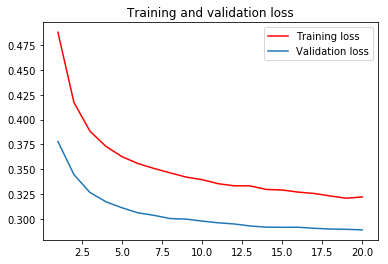

In [58]:
import matplotlib.pyplot as plt
%matplotlib inline
history.history

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Judging from the validation loss, this setup isn’t as good as the regularized GRU alone, but it’s significantly faster. It looks at twice as much data, which in this case doesn’t appear to be hugely helpful but may be important for other datasets.